In [1]:
import json
from collections.abc import Callable
from typing import (
  Any,
  TypeVar,
  cast,
)

import matplotlib.pyplot as plt
import networkx as nx
from openai import OpenAI
from openai.types.chat import (
  ChatCompletionMessageParam,
  ChatCompletionSystemMessageParam,
  ChatCompletionToolMessageParam,
  ChatCompletionToolParam,
  ChatCompletionUserMessageParam,
)
from pydantic import BaseModel, Field

T = TypeVar("T", bound=BaseModel)

# Prompt Management Module

A type-safe, flexible system for handling different types of completions with OpenAI's API.

## Core Components

### CompletionConfig

```python
class CompletionConfig(BaseModel):
    """Configuration for completions with type safety"""
    model: str = "gpt-4o-mini"
    temperature: float = Field(default=0.7, ge=0.0, le=2.0)
    max_tokens: int | None = Field(default=None, gt=0)
    system_message: str | None = None
    tools: list[ChatCompletionToolParam] | None = None
    response_format: type[T] | None = None
```

A Pydantic model that provides type-safe configuration for completions, supporting:

- Model selection
- Temperature control
- Token limits
- System messages
- Function calling tools
- Structured response formats

### PromptHandler

```python
class PromptHandler:
    """Unified prompt handler that automatically selects appropriate mode:
    1. If response_format provided -> Structured Pydantic response
    2. If tools provided -> Tool calling
    3. Otherwise -> Plain text completion
    """

    def __init__(self, api_key: str | None = None):
        self.client = OpenAI(api_key=api_key)

    def complete[T](
        self,
        instruction: str,
        *,
        config: CompletionConfig | None = None,
        context_functions: dict[str, Callable[..., Any]] | None = None,
    ) -> str | T:
        """Unified completion method that handles all response types"""
```

The main class that handles all prompt interactions, featuring:

- Automatic mode selection based on configuration
- Support for three completion modes:
  1. Structured responses using Pydantic models
  2. Tool/function calling with callback handling
  3. Standard text completions
- Type-safe response handling
- Proper error handling and validation

## Usage Examples

### Basic Text Completion

```python
handler = PromptHandler()
response = handler.complete(
    "Summarize the benefits of exercise",
    config=CompletionConfig(
        temperature=0.7,
        max_tokens=100
    )
)
```

### Structured Response

```python
class PersonInfo(BaseModel):
    name: str
    age: int
    occupation: str

config = CompletionConfig(
    response_format=PersonInfo,
    system_message="Extract person information from text"
)

person_info = handler.complete(
    "John is a 32 year old software engineer",
    config=config
)
# Returns a PersonInfo object
```

### Tool Calling

```python
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get weather for a location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {"type": "string"}
                }
            }
        }
    }
]

def get_weather(location: str) -> str:
    return f"Weather data for {location}"

config = CompletionConfig(tools=tools)
response = handler.complete(
    "What's the weather in London?",
    config=config,
    context_functions={"get_weather": get_weather}
)
```

## Features

- **Type Safety**: Full type hints and Pydantic validation
- **Flexible Configuration**: Easily configurable for different use cases
- **Mode Auto-detection**: Automatically selects the appropriate completion mode
- **Error Handling**: Comprehensive error checking and validation
- **Tool Integration**: Seamless integration with function calling
- **Structured Data**: Support for structured responses using Pydantic models

## Dependencies

- `openai`: OpenAI API client
- `pydantic`: Data validation and settings management
- Python 3.12+ (for type hints)

This module provides a robust foundation for handling AI completions in a type-safe and flexible manner, making it easy to integrate into larger applications while maintaining clean separation of concerns.


In [2]:
class CompletionConfig(BaseModel):
  """Configuration for completions with type safety"""

  model: str = "gpt-4o-mini"
  temperature: float = Field(
    default=0.7, ge=0.0, le=2.0
  )
  max_tokens: int | None = Field(default=None, gt=0)
  system_message: str | None = None
  tools: list[ChatCompletionToolParam] | None = None
  response_format: type[T] | None = None


class PromptHandler:
  """Unified prompt handler that automatically selects appropriate mode:
  1. If response_format provided -> Structured Pydantic response
  2. If tools provided -> Tool calling
  3. Otherwise -> Plain text completion
  """

  def __init__(self, api_key: str | None = None):
    self.client = OpenAI(api_key=api_key)

  def _build_messages(
    self,
    instruction: str,
    config: CompletionConfig,
  ) -> list[ChatCompletionMessageParam]:
    """Builds message list for completion request"""
    messages: list[ChatCompletionMessageParam] = []

    if config.system_message:
      messages.append(
        ChatCompletionSystemMessageParam(
          role="system",
          content=config.system_message,
        ),
      )

    messages.append(
      ChatCompletionUserMessageParam(
        role="user",
        content=instruction,
      ),
    )

    return messages

  def complete[T](
    self,
    instruction: str,
    *,
    config: CompletionConfig | None = None,
    context_functions: dict[str, Callable[..., Any]]
    | None = None,
  ) -> str | T:
    """Unified completion method that handles all response types

    Args:
        instruction: The prompt instruction
        config: Optional completion configuration
        context_functions: Required when using tools

    Returns:
        String response or parsed Pydantic model

    Raises:
        ValueError: If tools used without context_functions
        ValueError: If no content in response
    """
    config = config or CompletionConfig()
    messages = self._build_messages(
      instruction, config
    )

    # Case 1: Structured Pydantic response
    if config.response_format is not None:
      response = (
        self.client.beta.chat.completions.parse(
          model=config.model,
          messages=messages,
          response_format=config.response_format,
          temperature=config.temperature,
          max_tokens=config.max_tokens,
        )
      )

      parsed = response.choices[0].message.parsed
      if parsed is None:
        raise ValueError("Failed to parse response")

      return parsed

    # Case 2: Tool calling
    if config.tools is not None:
      if context_functions is None:
        raise ValueError(
          "context_functions required when using tools"
        )

      response = self.client.chat.completions.create(
        model=config.model,
        messages=messages,
        tools=config.tools,
        temperature=config.temperature,
        max_tokens=config.max_tokens,
      )

      if response.choices[0].message.tool_calls:
        for tool_call in response.choices[
          0
        ].message.tool_calls:
          function_name = tool_call.function.name
          function_args = json.loads(
            tool_call.function.arguments
          )

          if function_name not in context_functions:
            raise ValueError(
              f"Tool '{function_name}' not found"
            )

          result = context_functions[function_name](
            **function_args
          )
          messages.append(
            ChatCompletionToolMessageParam(
              role="tool",
              tool_call_id=tool_call.id,
              content=str(result),
            ),
          )

        response = self.client.chat.completions.create(
          model=config.model,
          messages=messages,
          temperature=config.temperature,
          max_tokens=config.max_tokens,
        )

    # Case 3: Plain text completion
    response = self.client.chat.completions.create(
      model=config.model,
      messages=messages,
      temperature=config.temperature,
      max_tokens=config.max_tokens,
    )

    content = response.choices[0].message.content
    if content is None:
      raise ValueError("No content in response")

    return content

## Prompt Examples


In [3]:
# First, let's define our Pydantic models for structured output
class TaskItem(BaseModel):
  """Represents a single task in the breakdown"""

  title: str = Field(
    ..., description="Title of the task"
  )
  description: str = Field(
    ...,
    description="Detailed description of what needs to be done",
  )
  estimated_hours: float = Field(
    ..., description="Estimated hours to complete"
  )
  priority: int = Field(
    ...,
    description="Priority from 1 (highest) to 5 (lowest)",
  )


class TaskBreakdown(BaseModel):
  """Represents a complete task breakdown"""

  project_name: str = Field(
    ..., description="Name of the project"
  )
  total_tasks: int = Field(
    ..., description="Total number of tasks"
  )
  tasks: list[TaskItem] = Field(
    ..., description="List of tasks"
  )
  estimated_total_hours: float = Field(
    ..., description="Total estimated hours"
  )


# Example using the PromptHandler with structured output
def main():
  # Initialize the prompt handler
  handler = PromptHandler()

  # Create a completion config with structured output
  config = CompletionConfig(
    model="gpt-4o-mini",
    temperature=0.7,
    system_message="""You are a project management expert who breaks down projects
        into detailed tasks. Provide structured task breakdowns that are realistic and actionable.""",
    response_format=TaskBreakdown,
  )

  # Example project description
  project_description = """
    Create a mobile app for tracking daily water intake. The app should:
    - Allow users to log their water consumption
    - Send reminders throughout the day
    - Show progress visualizations
    - Support multiple user profiles
    """

  # Format the instruction
  instruction = f"""
    Please break down the following project into detailed tasks:

    Project Description:
    {project_description}

    Provide a structured breakdown including task descriptions, estimated hours,
    and priorities. Be specific and realistic with the estimates.
    """

  try:
    # Get structured response
    result: TaskBreakdown = handler.complete(
      instruction, config=config
    )

    # Print the results in a formatted way
    print(f"\nProject: {result.project_name}")
    print(f"Total Tasks: {result.total_tasks}")
    print(
      f"Total Estimated Hours: {result.estimated_total_hours}"
    )
    print("\nTask Breakdown:")

    for i, task in enumerate(result.tasks, 1):
      print(
        f"\n{i}. {task.title} (Priority: {task.priority})"
      )
      print(f"   Description: {task.description}")
      print(
        f"   Estimated Hours: {task.estimated_hours}"
      )

  except Exception as e:
    print(f"Error: {e}")


main()


Project: Daily Water Intake Tracker App
Total Tasks: 12
Total Estimated Hours: 88.0

Task Breakdown:

1. Define App Requirements (Priority: 1)
   Description: Gather and document all functional and non-functional requirements for the app including user stories, use cases, and acceptance criteria.
   Estimated Hours: 8.0

2. Create Wireframes and UI Design (Priority: 1)
   Description: Design wireframes and user interface for the app to ensure usability and a good user experience. Include screens for logging water, reminders, progress visualizations, and user profiles.
   Estimated Hours: 16.0

3. Set Up Development Environment (Priority: 2)
   Description: Prepare the development environment by installing necessary tools and frameworks (e.g., Android Studio, Xcode, etc.) and creating the initial project structure.
   Estimated Hours: 4.0

4. Develop User Authentication Module (Priority: 1)
   Description: Implement user authentication to allow users to create and manage multiple profi

# Planning


In [4]:
class TaskContext(BaseModel):
  """Runtime context for task execution"""

  working_memory: dict[str, Any] = Field(
    default_factory=dict
  )
  functions: dict[str, Any]
  instructions: dict[str, str]
  prompt_configs: dict[str, CompletionConfig] = Field(
    default_factory=dict
  )


class TaskInput(BaseModel):
  """Represents an input to a task"""

  key: str  # The name of the input as expected by the task
  description: str
  source_key: str | None = Field(
    default=None,
    description="The name of the output/memory key that maps to this input",
  )


class Task(BaseModel):
  """Declarative task definition"""

  name: str
  inputs: list[TaskInput]
  output_key: str
  description: str
  tool_name: str | None = Field(
    default=None,
    description="Name of the tool this task uses, if any",
  )

  def get_input_mapping(self) -> dict[str, str]:
    """Returns a mapping of task input names to their source keys"""
    return {
      input.key: input.source_key or input.key
      for input in self.inputs
    }


class TaskSystem(BaseModel):
  """Complete task system with validation"""

  tasks: dict[str, Task]

  def get_task_graph(self) -> Any:
    """Creates a directed graph of task dependencies"""
    G: Any = nx.DiGraph()

    # Add all tasks as nodes with explicit typing for attributes
    for task in self.tasks.values():
      G.add_node(task.name, output=task.output_key)

    # Add edges for dependencies
    for task in self.tasks.values():
      for input in task.inputs:
        producer = next(
          (
            t
            for t in self.tasks.values()
            if t.output_key == input.key
          ),
          None,
        )
        if producer:
          G.add_edge(producer.name, task.name)

    return G

  def visualize(self) -> None:
    """Visualizes the task dependency graph"""
    G: Any = self.get_task_graph()
    pos: Any = nx.spring_layout(G, seed=42)

    _ = plt.figure(figsize=(12, 8))
    nx.draw(
      G,
      pos,
      with_labels=True,
      node_color="lightblue",
      node_size=2000,
      font_size=10,
      font_weight="bold",
    )

    # Add output keys as node labels
    output_labels = {
      task.name: f"{task.name}\n({task.output_key})"
      for task in self.tasks.values()
    }
    nx.draw_networkx_labels(G, pos, output_labels)

    _ = plt.title("Task Dependency Graph")
    plt.show()

  def validate_dependencies(
    self, context: TaskContext
  ):
    """Validates that all task dependencies can be resolved

    Args:
        context: TaskContext containing working memory and functions
    """
    G: Any = self.get_task_graph()
    if not nx.is_directed_acyclic_graph(G):
      raise ValueError("Task graph contains cycles")

    # Track all available outputs from tasks
    available_outputs = {
      task.output_key for task in self.tasks.values()
    }

    # Ensure all inputs have producers or are in working memory
    for task in self.tasks.values():
      input_mapping = task.get_input_mapping()
      for input in task.inputs:
        source_key = input_mapping[
          input.key
        ]  # Get the mapped source key
        if (
          source_key not in context.working_memory
          and source_key not in available_outputs
        ):
          raise ValueError(
            f"No task produces required input '{source_key}' (mapped from '{input.key}') "
            f"for task '{task.name}' and it's not present in working memory"
          )


class TaskExecutor:
  """Handles task execution with dependency resolution"""

  def __init__(
    self,
    system: TaskSystem,
    context: TaskContext,
    prompt_handler: PromptHandler | None = None,
  ):
    self.system = system
    self.context = context
    self.prompt_handler = (
      prompt_handler or PromptHandler()
    )
    self._execution_stack: set[str] = set()

  def is_prompt_task(self, task_name: str) -> bool:
    """Determines if a task is a prompt task"""
    task = self.system.tasks[task_name]
    if isinstance(task, PlanTask):
      return False
    return task_name not in self.context.functions

  def execute_task(self, task: Task) -> str:
    """Executes a single task with input mapping"""
    # Get the input mapping
    input_mapping = task.get_input_mapping()

    # Gather input values with mapping
    input_values = {}
    for input in task.inputs:
      source_key = input_mapping[input.key]
      if source_key not in self.context.working_memory:
        raise ValueError(
          f"Missing required input: {source_key}"
        )
      input_values[input.key] = (
        self.context.working_memory[source_key]
      )

    if isinstance(task, PlanTask):
      result = execute_plan_task(task, **input_values)
    elif task.tool_name:  # Execute tool
      if task.tool_name not in self.context.functions:
        raise ValueError(
          f"Tool not found: {task.tool_name}"
        )
      result = cast(
        str,
        self.context.functions[task.tool_name](
          **input_values
        ),
      )
    else:  # Execute prompt
      if task.name not in self.context.instructions:
        raise ValueError(
          f"No instructions found for prompt task: {task.name}"
        )

      config = self.context.prompt_configs.get(
        task.name, CompletionConfig()
      )
      instruction = self.context.instructions[
        task.name
      ].format(**input_values)
      result = self.prompt_handler.complete(
        instruction,
        config=config,
        context_functions=self.context.functions,
      )

    self.context.working_memory[task.output_key] = (
      result
    )
    return result

  def resolve_and_execute(self, task_name: str) -> str:
    """Resolves dependencies and executes a task"""
    if task_name in self._execution_stack:
      raise ValueError(
        f"Circular dependency detected for task: {task_name}"
      )

    self._execution_stack.add(task_name)
    task = self.system.tasks[task_name]

    try:
      # Resolve dependencies first
      for input in task.inputs:
        if (
          input.key not in self.context.working_memory
        ):
          producer_task = next(
            (
              t
              for t in self.system.tasks.values()
              if t.output_key == input.key
            ),
            None,
          )
          if producer_task:
            self.resolve_and_execute(
              producer_task.name
            )

      return self.execute_task(task)

    finally:
      self._execution_stack.remove(task_name)


class Plan(BaseModel):
  """Represents a high-level goal with its execution context"""

  name: str
  description: str
  desired_outputs: list[str]  # Keys we want to produce
  tasks: dict[str, Task]
  functions: dict[str, Callable[..., Any]] = Field(
    default_factory=dict,
  )
  instructions: dict[str, str] = Field(
    default_factory=dict,
  )
  prompt_configs: dict[str, CompletionConfig] = Field(
    default_factory=dict,
  )
  initial_context: dict[str, Any] = Field(
    default_factory=dict,
  )

  def create_task_system(self) -> TaskSystem:
    """Creates a TaskSystem from this plan"""
    return TaskSystem(tasks=self.tasks)

  def create_context(self) -> TaskContext:
    """Creates initial TaskContext for this plan"""
    return TaskContext(
      working_memory=self.initial_context.copy(),
      functions=self.functions,
      instructions=self.instructions,
      prompt_configs=self.prompt_configs,
    )

  def get_task_graph(
    self, include_nested: bool = True
  ) -> nx.DiGraph:
    """Creates a directed graph of task dependencies

    Args:
        include_nested: If True, includes tasks from nested plans

    Returns:
        A directed graph representing task dependencies
    """
    G = nx.DiGraph()

    # Add all tasks as nodes
    for task in self.tasks.values():
      node_attrs = {
        "output": task.output_key,
        "type": "plan_task"
        if isinstance(task, PlanTask)
        else "task",
      }
      G.add_node(task.name, **node_attrs)

      # If it's a PlanTask and we want to include nested tasks
      if include_nested and isinstance(task, PlanTask):
        nested_graph = task.plan.get_task_graph()
        # Add prefix to nested task names to avoid conflicts
        nested_graph = nx.relabel_nodes(
          nested_graph,
          lambda x: f"{task.name}/{x}",
        )
        G = nx.compose(G, nested_graph)
        # Add edge from nested plan's output to parent task
        output_task = next(
          t
          for t in task.plan.tasks.values()
          if t.output_key
          == task.plan.desired_outputs[0]
        )
        G.add_edge(
          f"{task.name}/{output_task.name}",
          task.name,
        )

    # Add edges for dependencies
    for task in self.tasks.values():
      for input in task.inputs:
        producer = next(
          (
            t
            for t in self.tasks.values()
            if t.output_key == input.key
          ),
          None,
        )
        if producer:
          G.add_edge(producer.name, task.name)

    return G

  def visualize(
    self, include_nested: bool = True
  ) -> None:
    """Visualizes the plan's task dependency graph

    Args:
        include_nested: If True, includes tasks from nested plans
    """
    G = self.get_task_graph(include_nested)
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    # Draw nodes with different colors based on type
    plan_tasks = [
      n
      for n, d in G.nodes(data=True)
      if d.get("type") == "plan_task"
    ]
    regular_tasks = [
      n
      for n, d in G.nodes(data=True)
      if d.get("type") == "task"
    ]

    nx.draw_networkx_nodes(
      G,
      pos,
      nodelist=regular_tasks,
      node_color="lightblue",
      node_size=2000,
    )
    nx.draw_networkx_nodes(
      G,
      pos,
      nodelist=plan_tasks,
      node_color="lightgreen",
      node_size=2000,
    )

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Add labels with output keys
    labels = {
      task: f"{task}\n({G.nodes[task]['output']})"
      for task in G.nodes()
    }
    nx.draw_networkx_labels(G, pos, labels)

    plt.title(
      f"Task Dependency Graph for Plan: {self.name}"
    )
    plt.show()


class PlanTask(Task):
  """A Task that executes a Plan"""

  # Add plan as a model field
  plan: Plan = Field(
    ...,  # ... means the field is required
    description="The plan this task executes",
  )

  @classmethod
  def from_plan(cls, plan: Plan) -> "PlanTask":
    """Creates a PlanTask from a Plan

    Args:
        plan: The Plan to execute

    Returns:
        A PlanTask instance
    """
    # Get input keys from both initial context and task inputs
    input_keys = set(plan.initial_context.keys())
    for task in plan.tasks.values():
      input_keys.update(k.key for k in task.inputs)

    return cls(
      name=plan.name,
      inputs=[
        TaskInput(key=k, description=f"Input {k}")
        for k in input_keys
      ],
      output_key=plan.desired_outputs[0],
      description=plan.description,
      plan=plan,  # Pass plan as a field
    )


class PlanExecutor:
  """Executes plans to achieve desired outputs"""

  def __init__(
    self,
    prompt_handler: PromptHandler | None = None,
  ):
    self.prompt_handler = (
      prompt_handler or PromptHandler()
    )

  def execute(
    self,
    plan: Plan,
    initial_context: dict[str, Any] | None = None,
  ) -> dict[str, Any]:
    """
    Executes a plan to produce desired outputs

    Args:
        plan: The Plan to execute
        initial_context: Optional initial context to merge with plan's context

    Returns:
        Dictionary mapping output keys to their values

    Raises:
        ValueError: If no task produces a required output
        ValueError: If dependencies cannot be resolved
    """
    system = plan.create_task_system()
    context = plan.create_context()

    # Merge provided initial context if any
    if initial_context:
      context.working_memory.update(initial_context)

    # Validate plan can produce desired outputs
    available_outputs = {
      task.output_key for task in plan.tasks.values()
    }
    for output in plan.desired_outputs:
      if output not in available_outputs:
        raise ValueError(
          f"No task produces required output: {output}"
        )

    # Validate dependencies
    system.validate_dependencies(context)

    # Create executor
    executor = TaskExecutor(
      system, context, self.prompt_handler
    )

    # Find and execute tasks that produce desired outputs
    results = {}
    for output in plan.desired_outputs:
      producer_task = next(
        task
        for task in plan.tasks.values()
        if task.output_key == output
      )
      result = executor.resolve_and_execute(
        producer_task.name
      )
      results[output] = result

    return results


def execute_plan_task(
  plan_task: PlanTask, **inputs: Any
) -> Any:
  """
  Function to execute a PlanTask

  Args:
      plan_task: The PlanTask to execute
      **inputs: Input values for the plan

  Returns:
      The result of executing the plan
  """
  updated_plan = Plan(
    name=plan_task.plan.name,
    description=plan_task.plan.description,
    desired_outputs=plan_task.plan.desired_outputs,
    tasks=plan_task.plan.tasks,
    functions=plan_task.plan.functions,
    instructions=plan_task.plan.instructions,
    prompt_configs=plan_task.plan.prompt_configs,
    initial_context=inputs,
  )

  executor = PlanExecutor()
  results = executor.execute(updated_plan)
  return results[updated_plan.desired_outputs[0]]

## Planning Example


In [5]:
# Example function
def get_project_request(project_id: str) -> str:
  return f"Project request details for {project_id}"


Visualization with nested tasks:


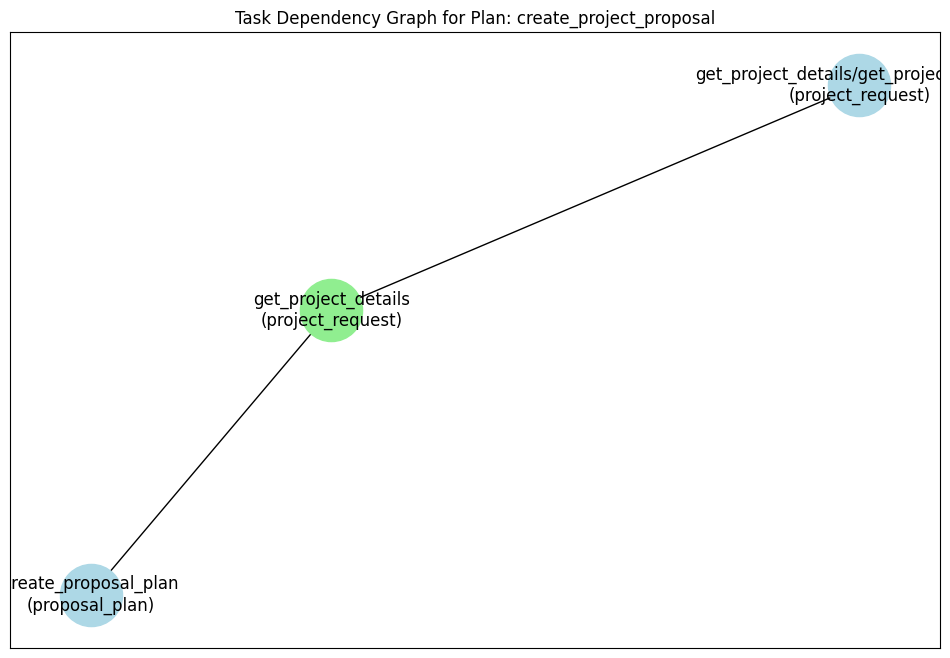


Visualization of top-level tasks only:


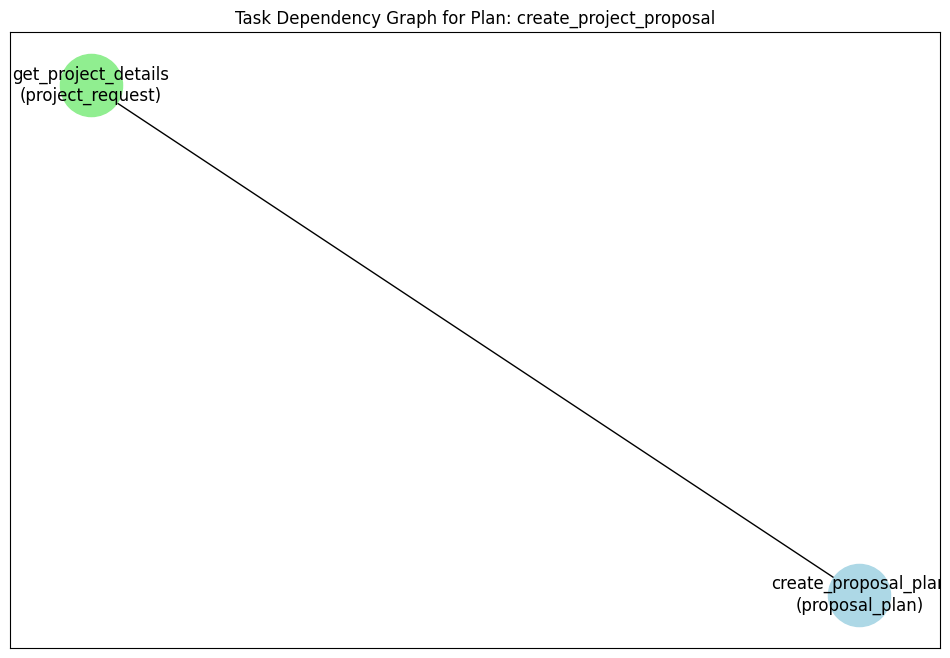


Proposal Plan:
# Project Proposal Plan for Project 123

## 1. Project Overview

### Project Title: 
Project 123

### Objective: 
The primary objective of Project 123 is to [insert specific objective, e.g., "develop a new software application that improves customer engagement and streamlines communication between departments"]. 

### Scope: 
The project will encompass the following key deliverables:
- [Deliverable 1: e.g., "Design and prototype of the application"]
- [Deliverable 2: e.g., "Implementation of core features"]
- [Deliverable 3: e.g., "User testing and feedback incorporation"]
- [Deliverable 4: e.g., "Deployment and training for end-users"]

### Stakeholders: 
- Project Sponsor: [Name, Title]
- Project Manager: [Name]
- Project Team: [List of team members and roles]
- End-users: [Describe user group]

### Success Criteria: 
The project will be deemed successful if:
- The application is delivered on time and within budget.
- User acceptance testing scores are above [insert p

In [8]:
def main() -> None:
  # Define a nested plan for handling project requests
  request_plan = Plan(
    name="get_project_details",
    description="Retrieves and formats project request details",
    desired_outputs=["project_request"],
    tasks={
      "get_project_request": Task(
        name="get_project_request",
        inputs=[
          TaskInput(
            key="project_id",
            description="Project ID",
          )
        ],
        output_key="project_request",
        description="Retrieves project request details",
        tool_name="get_project_request",
      ),
    },
    functions={
      "get_project_request": get_project_request
    },
  )

  # Create main proposal plan that uses the nested plan
  proposal_plan = Plan(
    name="create_project_proposal",
    description="Creates a detailed project proposal from a project ID",
    desired_outputs=["proposal_plan"],
    tasks={
      "get_project_details": PlanTask.from_plan(
        request_plan,
      ),
      "create_proposal_plan": Task(
        name="create_proposal_plan",
        inputs=[
          TaskInput(
            key="project_request",
            description="Project request",
          )
        ],
        output_key="proposal_plan",
        description="Creates a proposal plan",
      ),
    },
    instructions={
      "create_proposal_plan": """
      Based on the following project request, create a detailed proposal plan:

      Project Request: {project_request}

      Please include:
      1. Project overview
      2. Timeline
      3. Resource requirements
      4. Risk assessment
      5. Budget estimation
      """
    },
    prompt_configs={
      "create_proposal_plan": CompletionConfig(
        system_message="You are an expert project manager helping to create detailed project proposals.",
        temperature=0.7,
        model="gpt-4o-mini",
        max_tokens=1000,
      )
    },
    # Set initial context at the top level
    initial_context={"project_id": "123"},
  )

  # Visualize the plan structure
  print("\nVisualization with nested tasks:")
  proposal_plan.visualize(include_nested=True)

  print("\nVisualization of top-level tasks only:")
  proposal_plan.visualize(include_nested=False)

  # Execute plan
  executor = PlanExecutor()
  results = executor.execute(proposal_plan)

  print("\nProposal Plan:")
  print(results["proposal_plan"])


main()

## Dyanmic Planning Example



Attempt 1/3

Parsed Result:
Name: Handle Project Requests
Description: A plan to process incoming project requests through retrieval and sentiment analysis.
Desired Outputs: ['response']

Tasks:

  Retrieve Project Request:
    Description: Retrieves project request details
    Output: request_text
    Tool: get_project_request
    Inputs:
      - project_id -> project_id: The ID of the project

  Analyze Request Sentiment:
    Description: Analyzes sentiment of the request
    Output: sentiment
    Tool: analyze_sentiment
    Inputs:
      - text -> request_text: The request text to analyze

  Generate Project Request Summary:
    Description: Generate a summarized response for the project request considering its sentiment
    Output: response
    Tool: summary_tool
    Inputs:
      - request_text -> request_text: The project request text to summarize
      - sentiment -> sentiment: The sentiment analysis of the project request

Validating plan dependencies...
✓ Plan validation succ

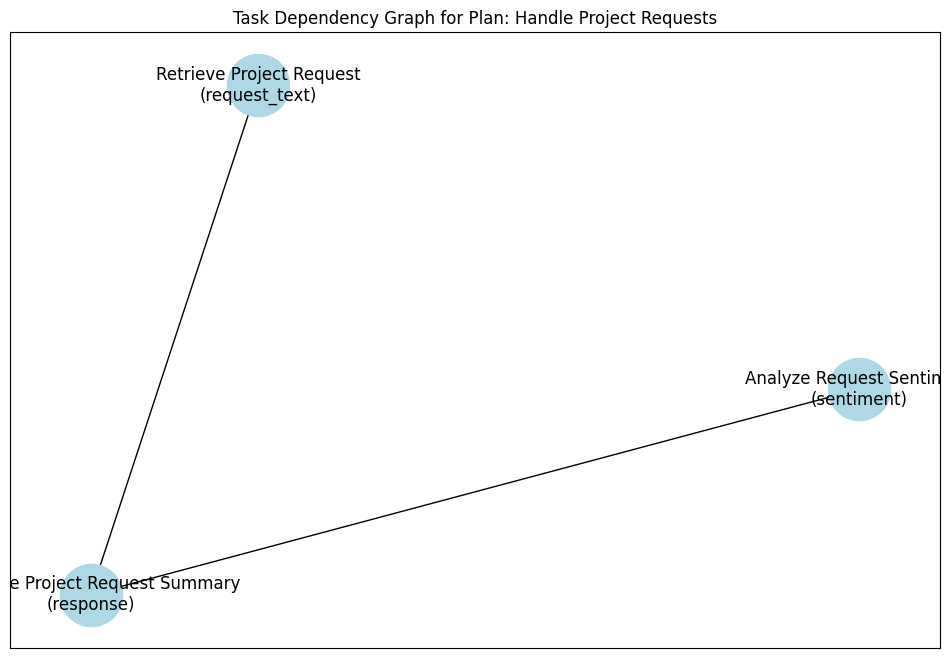


Executing plan...


ValueError: Tool not found: summary_tool

In [7]:
class PlanSpecification(BaseModel):
  """Specification for dynamically creating a Plan"""

  name: str
  description: str
  desired_outputs: list[str]
  tasks: list[Task]

  class Config:
    json_schema_extra = {
      "example": {
        "name": "Handle Project Requests",
        "description": "A plan to handle project requests",
        "desired_outputs": ["response"],
        "tasks": [
          {
            "name": "Retrieve Project Request",
            "tool_name": "get_project_request",
            "description": "Retrieves project request details",
            "output_key": "request_text",
            "inputs": [
              {
                "key": "project_id",
                "source_key": "project_id",
                "description": "The ID of the project",
              }
            ],
          },
          {
            "name": "Analyze Request Sentiment",
            "tool_name": "analyze_sentiment",
            "description": "Analyzes sentiment of the request",
            "output_key": "sentiment",
            "inputs": [
              {
                "key": "text",
                "source_key": "request_text",
                "description": "The text to analyze",
              }
            ],
          },
        ],
      }
    }


def generate_plan_specification(
  handler: PromptHandler,
  available_inputs: dict[str, str],
  available_tools: dict[str, dict[str, Any]],
  available_instructions: dict[str, str],
  previous_attempt: dict[str, Any] | None = None,
) -> PlanSpecification:
  """Generates a plan specification with validation error feedback and previous attempt

  Args:
      handler: PromptHandler instance
      available_inputs: Dictionary of available input types
      available_tools: Dictionary of available tools and their specs
      available_instructions: Dictionary of available instructions
      previous_attempt: Optional dict containing previous attempt info
          {
              'plan': PlanSpecification,
              'errors': list[str]
          }

  Returns:
      PlanSpecification instance
  """
  instruction = f"""
    Please create a plan for handling project requests with the following available tools and instructions:

    Available Inputs:
    {json.dumps(available_inputs, indent=2)}

    Available Tools:
    {json.dumps(available_tools, indent=2)}

    Available Instructions:
    {json.dumps(available_instructions, indent=2)}

    The plan should:
    1. Retrieve project request details
    2. Analyze the sentiment of the request
    3. Generate a summarized response considering both the request and its sentiment

    IMPORTANT: For each task input, you must specify:
    - key: The parameter name required by the tool (e.g., 'text' for analyze_sentiment)
    - source_key: The key in working memory or output from another task that provides the value (e.g., 'request_text')
    - description: Description of the input

    Example task using analyze_sentiment tool:
    {{
      "name": "Analyze Request Sentiment",
      "tool_name": "analyze_sentiment",
      "inputs": [
        {{
          "key": "text",           # Parameter name required by analyze_sentiment tool
          "source_key": "request_text",  # Maps to output from Retrieve Project Request task
          "description": "The request text to analyze"
        }}
      ],
      "output_key": "sentiment",
      "description": "Analyzes sentiment of the request"
    }}

    The task's inputs must map correctly between:
    1. What the tool expects (key)
    2. What's available in working memory or from other tasks (source_key)
    """

  if previous_attempt:
    instruction += f"""

    Previous attempt failed. Here are the details:

    Previous Plan Specification:
    {json.dumps(previous_attempt['plan'].model_dump(), indent=2)}

    Validation Errors:
    {json.dumps(previous_attempt['errors'], indent=2)}

    Please analyze the previous plan and its errors carefully, then create a new plan that addresses these issues.
    Focus particularly on fixing the dependency chain and ensuring all inputs are properly sourced.
    """

  response = handler.client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "system",
        "content": """You are a planning expert who creates task workflows.
            Create plans that effectively utilize available tools and instructions.
            When given a failed attempt, carefully analyze the errors and previous plan to create an improved version.""",
      },
      {"role": "user", "content": instruction},
    ],
    response_format=PlanSpecification,
  )

  result = response.choices[0].message.parsed
  if result is None:
    raise ValueError("Failed to parse response")

  return result


def main():
  # Initialize the prompt handler
  handler = PromptHandler()

  # Example inputs
  available_inputs = {
    "project_id": "string",
  }

  # Example available tools and instructions
  available_tools = {
    "get_project_request": {
      "name": "get_project_request",
      "description": "Retrieves project request details",
      "parameters": {"project_id": "string"},
      "returns": "string",
    },
    "analyze_sentiment": {
      "name": "analyze_sentiment",
      "description": "Analyzes sentiment of text",
      "parameters": {"text": "string"},
      "returns": "string",
    },
  }

  available_instructions = {
    "summarize_request": "Summarize the following project request: {request_text}",
    "generate_response": "Generate a response for the following request: {request_text} considering the sentiment: {sentiment}",
  }

  MAX_RETRIES = 3
  previous_attempt: dict[str, Any] | None = None
  plan: Plan | None = None  # Track successful plan

  for attempt in range(MAX_RETRIES):
    try:
      print(f"\nAttempt {attempt + 1}/{MAX_RETRIES}")

      # Generate plan specification with validation feedback
      result = generate_plan_specification(
        handler,
        available_inputs,
        available_tools,
        available_instructions,
        previous_attempt,
      )

      # Print the parsed result
      print("\nParsed Result:")
      print(f"Name: {result.name}")
      print(f"Description: {result.description}")
      print(
        f"Desired Outputs: {result.desired_outputs}"
      )

      print("\nTasks:")
      for task in result.tasks:
        print(f"\n  {task.name}:")
        print(f"    Description: {task.description}")
        print(f"    Output: {task.output_key}")
        if task.tool_name:
          print(f"    Tool: {task.tool_name}")
        print("    Inputs:")
        for input in task.inputs:
          mapping_info = (
            f" -> {input.source_key}"
            if input.source_key
            else ""
          )
          print(
            f"      - {input.key}{mapping_info}: {input.description}"
          )

      # Convert list of tasks to dictionary for Plan creation
      tasks_dict = {
        task.name: task for task in result.tasks
      }

      # Create actual Plan instance from specification
      plan = Plan(
        name=result.name,
        description=result.description,
        desired_outputs=result.desired_outputs,
        tasks=tasks_dict,
        functions={
          "get_project_request": get_project_request,
          "analyze_sentiment": lambda text: "positive",  # Dummy implementation
        },
        instructions=available_instructions,
        prompt_configs={},
        initial_context={"project_id": "PROJ123"},
      )

      # Create TaskSystem and TaskContext for validation
      system = plan.create_task_system()
      context = plan.create_context()

      print("\nValidating plan dependencies...")
      system.validate_dependencies(context)
      print("✓ Plan validation successful!")
      break  # Exit loop on success

    except ValueError as e:
      validation_errors = [str(e)]
      print(f"✗ Plan validation failed: {e}")

      # Store the failed attempt and its errors for the next iteration
      previous_attempt = {
        "plan": result
        if "result" in locals()
        else None,
        "errors": validation_errors,
      }

      if attempt == MAX_RETRIES - 1:
        print(
          "\nMax retries reached. Final validation errors:"
        )
        print("\n".join(validation_errors))

        if "system" in locals():
          print(
            "\nTask Graph (showing problematic dependencies):"
          )
          system.visualize()

          print(
            "\nDetailed task input/output analysis:"
          )
          for task_name, task in system.tasks.items():
            print(f"\nTask: {task_name}")
            print(f"Output Key: {task.output_key}")
            if task.tool_name:
              print(f"Tool: {task.tool_name}")
            print("Input Keys:")
            input_mapping = task.get_input_mapping()
            for input in task.inputs:
              source_key = input_mapping[input.key]
              producers = [
                t
                for t in system.tasks.values()
                if t.output_key == source_key
              ]
              if producers:
                print(
                  f"  - {input.key} -> {source_key} (provided by: {[t.name for t in producers]})"
                )
              elif (
                source_key in context.working_memory
              ):
                print(
                  f"  - {input.key} -> {source_key} (from working memory)"
                )
              else:
                print(
                  f"  - {input.key} -> {source_key} (no producer found)"
                )
        return  # Exit on max retries

    except Exception as e:
      print(f"Unexpected error: {e}")
      if attempt == MAX_RETRIES - 1:
        raise

  # Only proceed with visualization and execution if we have a valid plan
  if plan is not None:
    print("\nVisualizing plan...")
    plan.visualize()

    print("\nExecuting plan...")
    executor = PlanExecutor()
    outputs = executor.execute(plan)

    print("\nPlan Execution Results:")
    for key, value in outputs.items():
      print(f"{key}: {value}")


main()

# RFP Scenario


In [5]:
from textwrap import dedent

create_proposal_plan_guidelines = dedent(
  """
**Guidelines for Creating Step-by-Step Plans for Crafting Proposals in Response to RFPs/RFIs/RFQs**

---

**Table of Contents**

1. Introduction
2. Understanding RFPs, RFIs, and RFQs
3. General Principles for Crafting a Proposal Plan
4. Step-by-Step Plan Creation Guidelines
5. Defining Tasks and Artifacts
6. Establishing Evaluation Criteria
7. Leveraging Domain Knowledge and Resources
8. Best Practices for AI Agents in Proposal Development
9. Conclusion

---

### **1. Introduction**

This document provides comprehensive guidelines for creating detailed step-by-step plans to craft proposals in response to Requests for Proposals (RFPs), Requests for Information (RFIs), and Requests for Quotes (RFQs). These guidelines are intended to assist AI agents or teams in systematically developing winning proposals that meet client requirements and adhere to organizational best practices.

---

### **2. Understanding RFPs, RFIs, and RFQs**

Before creating a proposal plan, it is crucial to understand the differences between RFPs, RFIs, and RFQs, as each requires a tailored approach:

- **RFP (Request for Proposal):** A document issued by a client seeking proposals for a complex project, often requiring detailed solutions, methodologies, and pricing.

- **RFI (Request for Information):** A preliminary document requesting general information about a company's products, services, and capabilities, used to gather market intelligence.

- **RFQ (Request for Quote):** A document requesting pricing information for specific products or services, with an emphasis on cost details.

---

### **3. General Principles for Crafting a Proposal Plan**

When creating a proposal plan, consider the following principles:

- **Alignment with Client Requirements:** Ensure that all proposal content directly addresses the client's stated needs and objectives.

- **Clarity and Organization:** Structure the plan with clear sections, logical flow, and easy navigation to enhance readability and comprehension.

- **Specificity:** Define tasks and outputs precisely, avoiding vague or ambiguous language.

- **Tailoring to Proposal Type:** Adjust content depth and focus based on whether the response is for an RFP, RFI, or RFQ.

- **Evaluation Criteria:** Establish clear criteria for evaluating each task's output to ensure it meets quality standards and client expectations.

---

### **4. Step-by-Step Plan Creation Guidelines**

Follow these guidelines to develop a comprehensive step-by-step plan:

#### **4.1. Analyze the RFP/RFI/RFQ Document**

- **Task:** Carefully review the client's document to understand the scope, requirements, and objectives.
- **Output:** A summary of key requirements and deliverables.
- **Evaluation Criteria:** Ensure all client directives and requirements are identified.

#### **4.2. Identify Project Requirements**

- **Task:** Extract and document specific project requirements, challenges, and success factors.
- **Output:** A detailed list of requirements and constraints.
- **Evaluation Criteria:** Verify completeness and accuracy of all identified requirements.

#### **4.3. Understand the Client's Context**

- **Task:** Research the client's industry, market position, and unique challenges.
- **Output:** An analysis of the client's environment and needs.
- **Evaluation Criteria:** Assess relevance and depth of understanding.

#### **4.4. Define the Proposed Solution**

- **Task:** Outline a solution that addresses the client's requirements.
- **Output:** A high-level solution overview, including key features and differentiators.
- **Evaluation Criteria:** Check alignment with requirements and innovation in the proposed solution.

#### **4.5. Plan Proposal Sections According to Guidelines**

- **Task:** Structure the proposal using the recommended outline, adjusting for RFP/RFI/RFQ variations.
- **Output:** An organized proposal framework with designated sections.
- **Evaluation Criteria:** Confirm adherence to the provided outline and appropriate content allocation.

#### **4.6. Develop Each Proposal Section**

For each section (e.g., Executive Summary, Company Overview):

- **Task:** Draft content that fulfills the section's purpose, tailored to the client's needs.
- **Output:** Completed sections as per the proposal outline.
- **Evaluation Criteria:** Evaluate for clarity, relevance, professionalism, and compliance with guidelines.

#### **4.7. Specify Prerequisite Inputs for Each Task**

- **Task:** Identify necessary inputs for completing each task.
- **Output:** A list of inputs such as previous task outputs, domain knowledge, or external data.
- **Evaluation Criteria:** Ensure all required inputs are identified and accessible.

#### **4.8. Establish Evaluation Criteria**

- **Task:** Define criteria to assess the quality and effectiveness of each task's output.
- **Output:** Clear, measurable evaluation benchmarks.
- **Evaluation Criteria:** Criteria should be specific, relevant, and actionable.

#### **4.9. Leverage Domain Knowledge**

- **Task:** Utilize information from domain experts or agents to enrich proposal content.
- **Output:** Incorporation of company data, case studies, qualifications, and other relevant information.
- **Evaluation Criteria:** Verify the accuracy and integration of domain knowledge.

#### **4.10. Incorporate Visual Aids and Graphics**

- **Task:** Design graphics that enhance understanding of the proposal (e.g., solution diagrams, timelines).
- **Output:** Professional visuals integrated into the proposal.
- **Evaluation Criteria:** Assess graphics for clarity, relevance, and alignment with branding.

#### **4.11. Apply Professional Formatting and Branding**

- **Task:** Format the proposal to reflect consistent branding and professional presentation.
- **Output:** A polished document with cohesive styling.
- **Evaluation Criteria:** Check for consistency in fonts, styles, and adherence to branding guidelines.

#### **4.12. Review and QA the Proposal**

- **Task:** Conduct a thorough quality assurance review to identify and correct errors.
- **Output:** A revised proposal that meets all quality standards.
- **Evaluation Criteria:** Ensure the proposal is error-free, compliant, and ready for submission.

---

### **5. Defining Tasks and Artifacts**

For each step in the plan:

- **Define Clear Tasks:** Use specific action verbs to describe what needs to be done (e.g., "Develop," "Identify," "Draft").

- **Specify Outputs (Artifacts):** Describe the tangible content or documents produced (e.g., "A detailed list of requirements," "An Executive Summary section").

- **Identify Prerequisite Inputs:** List any prior outputs or information required to complete the task.

- **Set Evaluation Criteria:** Establish standards to measure the success and quality of the task's output.

---

### **6. Establishing Evaluation Criteria**

When creating evaluation criteria for each task:

- **Align with Objectives:** Criteria should reflect how well the output meets the client's needs and the proposal's goals.

- **Be Specific and Measurable:** Use quantifiable metrics where possible (e.g., "The summary is no longer than two pages," "All client requirements are addressed").

- **Ensure Quality and Compliance:** Include checks for accuracy, professionalism, and adherence to guidelines.

- **Consider Client Perspective:** Evaluate whether the output would satisfy the client's expectations and requirements.

---

### **7. Leveraging Domain Knowledge and Resources**

- **Use Internal Expertise:** Access information from domain agents or experts for accurate and comprehensive content.

- **Incorporate Company Assets:** Utilize existing materials such as case studies, service descriptions, and team profiles.

- **Stay Current:** Ensure all information reflects the most recent company data and industry trends.

---

### **8. Best Practices for AI Agents in Proposal Development**

- **Maintain Client Focus:** Keep the client's needs at the forefront throughout the proposal.

- **Ensure Consistency:** Use consistent terminology, style, and branding elements.

- **Stay Compliant:** Adhere strictly to any instructions, formats, or guidelines provided by the client.

- **Proofread Thoroughly:** Eliminate grammatical errors, typos, and inconsistencies.

- **Manage Time Effectively:** Allocate sufficient time for each task, including reviews and approvals, to meet submission deadlines.

- **Adapt to Proposal Type:** Modify the depth and focus of content based on whether it is an RFP, RFI, or RFQ.

---

### **9. Conclusion**

By following these guidelines, AI agents and teams can develop detailed, methodical plans for crafting effective proposals in response to RFPs, RFIs, and RFQs. The key is to remain client-focused, ensure clarity and precision in tasks and outputs, and maintain high standards of quality throughout the proposal development process.

---

**Appendix: Template for Creating a Step-by-Step Proposal Plan**

Below is a template that can be used when creating future proposal plans:

---

**Step X: [Title of the Step]**

**Task:**

- Describe the specific action to be taken.

**Prerequisite Inputs:**

- List required inputs (e.g., previous task outputs, domain knowledge).

**Content Produced (Artifacts):**

- Detail the expected outputs.

**Evaluation Criteria:**

- **Criterion 1:** Description.
- **Criterion 2:** Description.
- **Criterion 3:** Description.
- **Criterion N:** Description.

---

**Example:**

**Step 1: Identify Project Requirements**

**Task:**

- Extract and document all project requirements from the RFP.

**Prerequisite Inputs:**

- The RFP document.

**Content Produced:**

- A comprehensive list of the client's requirements, objectives, and success factors.

**Evaluation Criteria:**

- **Completeness:** All requirements from the RFP are captured.
- **Accuracy:** Requirements accurately reflect the client's needs.
- **Clarity:** Requirements are clearly and concisely stated.

---

By utilizing this template and adhering to the guidelines provided, the development of step-by-step plans for crafting proposals will become a streamlined and effective process, ultimately leading to the creation of compelling and successful proposals.
  """
).strip()

create_goal_oriented_plan_guidelines = dedent(
  """
# Guidelines for Converting Logical Plans into Goal-Oriented Execution Format

## Purpose

These guidelines help convert a logically structured proposal plan into a formal goal-oriented execution format that enables automated processing and tracking. This conversion maintains the original plan's logic while adding explicit dependencies, content flows, and measurable success criteria.

## Output Format Requirements

The output should be structured as a ProjectPlan containing:

1. A dictionary of ProjectGoal objects
2. A set of entry_points (initial goals that can start immediately)
3. A set of final_goals (goals that represent project completion)

Each ProjectGoal must specify:

- goal_id: Unique identifier
- description: Clear statement of the goal
- success_criteria: Specific, measurable criteria
- required_goals: Set of goal_ids that must complete first
- produces: Set of content types this goal will create
- requires: Set of content types needed as input

## Conversion Process

### 1. Identify Goals

- Convert each major step or task into a goal
- Ensure each goal represents a discrete, measurable outcome
- Create unique, descriptive goal_ids

### 2. Define Content Types

For each goal, identify:

- Input content required (requires)
  - Documents, data, or artifacts needed
  - Include both external inputs and outputs from other goals
- Output content produced (produces)
  - Specific deliverables or artifacts
  - Use clear, consistent naming conventions

### 3. Establish Dependencies

- Analyze the logical flow of the original plan
- Identify which goals must complete before others can start
- Map these as required_goals
- Ensure no circular dependencies

### 4. Define Success Criteria

Transform evaluation criteria into specific, measurable statements that:

- Can be objectively assessed
- Include quantitative measures where possible
- Cover all key requirements
- Enable automated or systematic evaluation

### 5. Identify Entry and Exit Points

- Mark goals with no prerequisites as entry_points
- Mark goals that represent final deliverables as final_goals

## Naming Conventions

### Goal IDs

- Use lowercase with underscores
- Make descriptive but concise
- Examples: requirements_analysis, technical_response

### Content Types

- Use lowercase with underscores
- Describe the actual content/artifact
- Examples: requirements_list, pricing_structure

## Example Conversion

Original Format:

```
Step: Document Review and Requirements Analysis
- Task: Thoroughly analyze the RFQ document
- Outputs:
  * Comprehensive list of requirements
  * Timeline tracking document
  * Initial risk assessment
- Evaluation Criteria:
  * All requirements captured
  * Key dates identified
  * Critical requirements highlighted
```

Converted Format:

```python
"requirements_analysis": ProjectGoal(
    goal_id="requirements_analysis",
    description="Analyze RFQ document and establish project framework",
    success_criteria=\"\"\"
        - Complete requirements list generated
        - All key dates identified and documented
        - Initial risks documented and categorized
    \"\"\",
    required_goals=set(),  # Initial step
    produces={
        "requirements_list",
        "timeline_tracking",
        "risk_assessment"
    },
    requires={
        "rfq_document"  # Initial input
    }
)
```

## Quality Checks

Verify that the converted plan:

1. Maintains all logical relationships from original plan
2. Has explicit content dependencies
3. Contains measurable success criteria
4. Forms a complete directed acyclic graph (no cycles)
5. Covers all original steps and deliverables
6. Has clear entry and exit points

## Special Considerations

### Handling Parallel Tasks

- Identify tasks that can run concurrently
- Ensure dependencies don't create unnecessary serialization
- Make parallel potential explicit through dependencies

### Managing Inputs and Outputs

- Be explicit about external inputs needed
- Ensure all produced content is consumed or represents a final deliverable
- Maintain clear content lineage

### Success Criteria

- Break down subjective criteria into measurable components
- Include both quality and completeness metrics
- Ensure criteria are actionable

## Common Pitfalls to Avoid

1. Over-serializing dependencies
2. Under-specifying content requirements
3. Vague success criteria
4. Missing intermediate content dependencies
5. Circular dependencies
6. Inconsistent naming conventions

## Final Validation

Before finalizing the conversion, verify:

1. All original steps are represented
2. All dependencies are captured
3. Content flow is complete and logical
4. Success criteria are measurable
5. Entry and exit points are clear
6. Naming is consistent
  """
).strip()